<a href="https://colab.research.google.com/github/shahtvisha/TextSummarizationUsingDeepLearning/blob/main/CNN_DailyMailTextSummarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [2]:
import datasets

In [3]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=69d106a39dfd47c2829025eadac0a7b8108f723aae39c9d3fd160c6427f199e7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, RepeatVector, Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import re
from rouge_score import rouge_scorer
from tensorflow.keras.models import load_model

In [5]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail",'3.0.0')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [7]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']


In [8]:
print("Number of items in each split:")
print("Training:", len(train_data['article']))
print("Validation:", len(val_data['article']))
print("Test:", len(test_data['article']))

Number of items in each split:
Training: 287113
Validation: 13368
Test: 11490


In [9]:
type(train_data)

datasets.arrow_dataset.Dataset

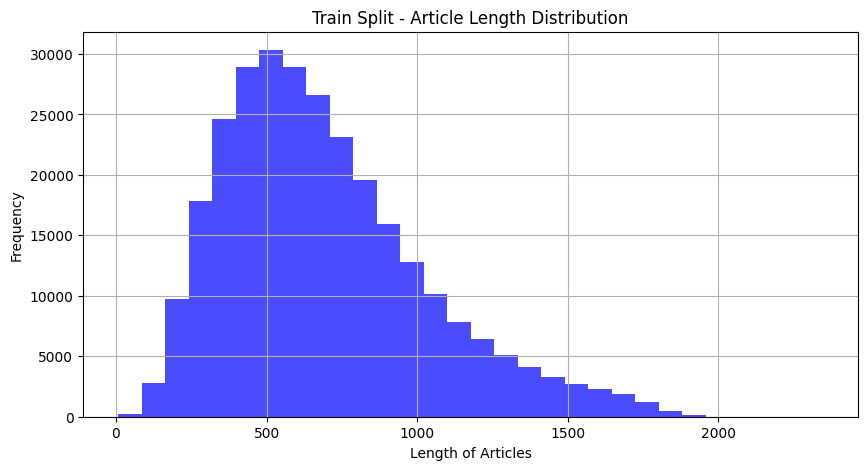

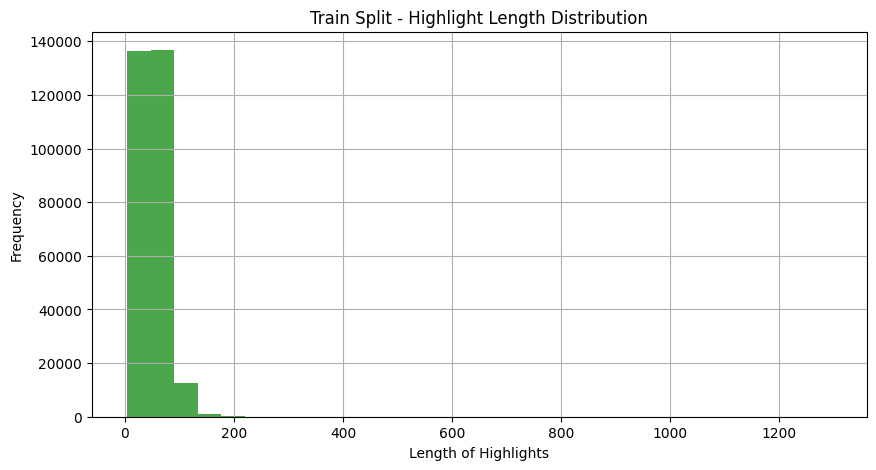


Summary statistics for train split - Article lengths:
Min: 8 Max: 2347 Mean: 691.8703263175126
Summary statistics for train split - Highlight lengths:
Min: 4 Max: 1296 Mean: 51.574101486174435


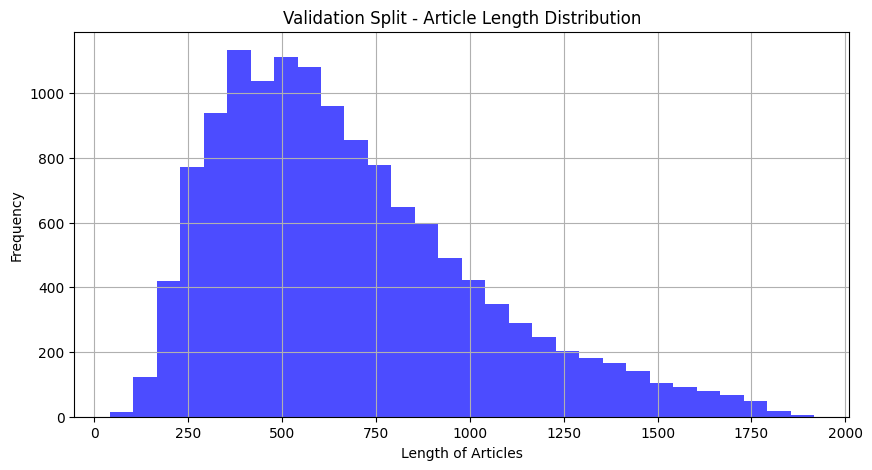

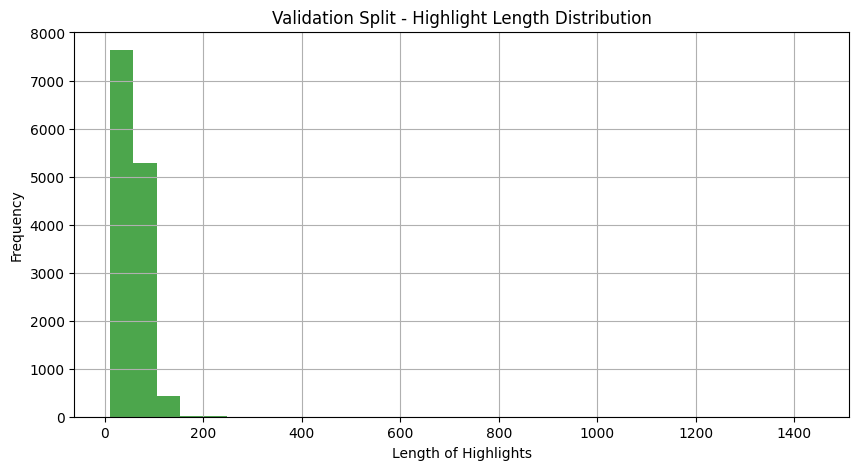


Summary statistics for validation split - Article lengths:
Min: 41 Max: 1917 Mean: 676.0264063435069
Summary statistics for validation split - Highlight lengths:
Min: 10 Max: 1440 Mean: 57.91008378216637


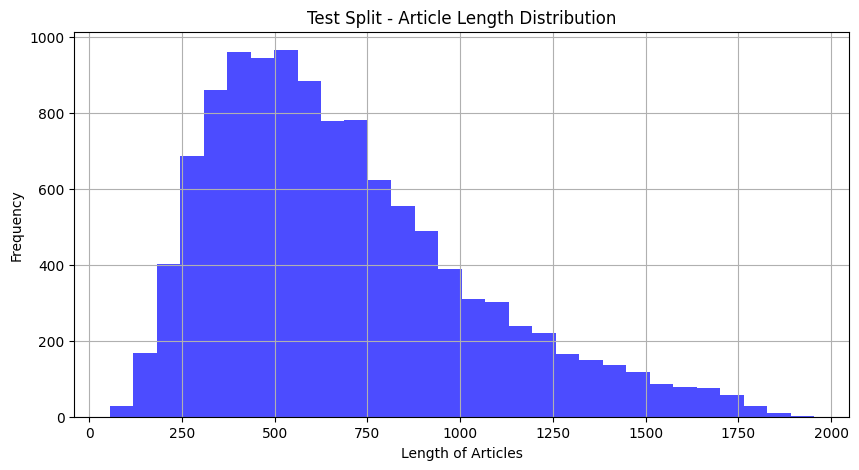

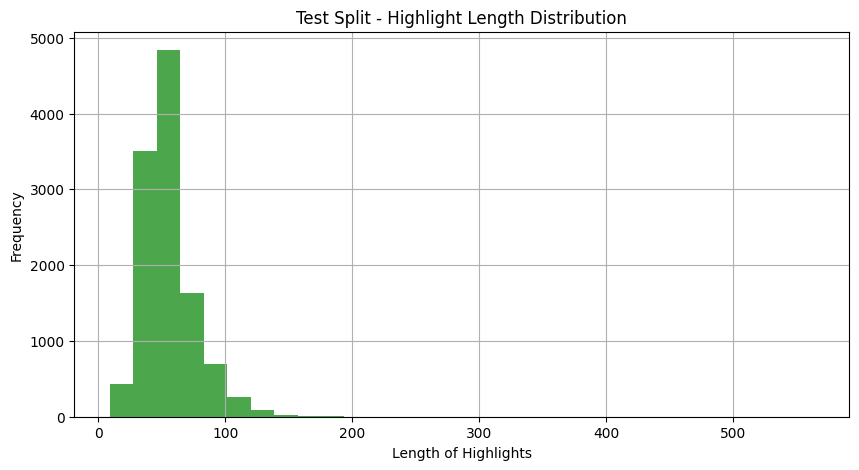


Summary statistics for test split - Article lengths:
Min: 55 Max: 1954 Mean: 683.5115752828547
Summary statistics for test split - Highlight lengths:
Min: 9 Max: 564 Mean: 55.00931244560488


In [10]:
def compute_summary_statistics(split):
    article_lengths = [len(article.split()) for article in split['article']]
    highlight_lengths = [len(highlight.split()) for highlight in split['highlights']]
    return article_lengths, highlight_lengths

# Compute summary statistics for article and highlight lengths
for split_name, split_data in dataset.items():
    article_lengths, highlight_lengths = compute_summary_statistics(split_data)

    # Plot histogram for article lengths
    plt.figure(figsize=(10, 5))
    plt.hist(article_lengths, bins=30, color='blue', alpha=0.7)
    plt.title(f'{split_name.capitalize()} Split - Article Length Distribution')
    plt.xlabel('Length of Articles')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Plot histogram for highlight lengths
    plt.figure(figsize=(10, 5))
    plt.hist(highlight_lengths, bins=30, color='green', alpha=0.7)
    plt.title(f'{split_name.capitalize()} Split - Highlight Length Distribution')
    plt.xlabel('Length of Highlights')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Print summary statistics
    print(f"\nSummary statistics for {split_name} split - Article lengths:")
    print("Min:", min(article_lengths), "Max:", max(article_lengths), "Mean:", sum(article_lengths) / len(article_lengths))
    print(f"Summary statistics for {split_name} split - Highlight lengths:")
    print("Min:", min(highlight_lengths), "Max:", max(highlight_lengths), "Mean:", sum(highlight_lengths) / len(highlight_lengths))


Preprocessing

In [11]:
def text_strip(column):
    preprocessed_text = []
    for row in column:
        row = re.sub("(\\t)", ' ', str(row)).lower()  # remove escape characters
        row = re.sub("(\\r)", ' ', str(row)).lower()
        row = re.sub("(\\n)", ' ', str(row)).lower()
        row = re.sub("(\.\.+)", ' ', str(row)).lower()   # remove . if it occurs more than one time consecutively

        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()  # remove <>()|&©ø"',;?~*!

        row = re.sub("(\.\s+)", ' ', str(row)).lower()  # remove full stop at end of words(not between)
        row = re.sub("(\-\s+)", ' ', str(row)).lower()  # remove - at end of words(not between)
        row = re.sub("(\:\s+)", ' ', str(row)).lower()  # remove : at end of words(not between)

        row = re.sub("(\s+.\s+)", ' ', str(row)).lower()  # remove any single characters hanging between 2 spaces
        row = re.sub(r'\n', ' ', str(row))# remove next line
        row = re.sub(r'(\s*\\n\s*)', ' ', row)  # Remove "\n" substring with surrounding spaces
        row= re.sub(r'\s+\.', '.', row)

        # Replace any URL with its domain
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(row))
        except:
            pass  # there might be emails with no URL in them

        row = re.sub("(\s+)", ' ', str(row)).lower()  # remove multiple spaces

        # Should always be last
        row = re.sub("(\s+.\s+)", ' ', str(row)).lower()  # remove any single characters hanging between 2 spaces

        preprocessed_text.append(row.strip())

    return preprocessed_text

In [12]:
# Initialize a dictionary to store preprocessed dataset
preprocessed_dataset = {}

# Preprocess the validation data
preprocessed_dataset['validation'] = []
for i, row in enumerate(dataset['validation']):
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'highlights' in row:
        preprocessed_row['highlights'] = text_strip([row['highlights']])[0]
    preprocessed_dataset['validation'].append(preprocessed_row)

# Display preprocessed dataset
for split, data in preprocessed_dataset.items():
    print(f"{split}:")
    for i, row in enumerate(data[:5]):  # Prints 5 elements
        print(f"Row {i+1}:")
        if 'article' in row:
            print(f"Article: {row['article']}")
        if 'highlights' in row:
            print(f"highlights: {row['highlights']}")
    print()


validation:
Row 1:
Article: cnn share and your gift will be multiplied that may sound like an esoteric adage but when zully broussard selflessly decided to give one of her kidneys to stranger her generosity paired up with big data it resulted in six patients receiving transplants that surprised and wowed her thought was going to help this one person who don know but the fact that so many people can have life extension that pretty big broussard told cnn affiliate kgo she may feel guided in her generosity by higher power thanks for all the support and prayers comment on facebook page in her name read know this entire journey is much bigger than all of us also know just the messenger cnn cannot verify the authenticity of the page but the power that multiplied broussard gift was data processing of genetic profiles from donor-recipient pairs it works on simple swapping principle but takes it to much higher level according to california pacific medical center in san francisco so high that it

In [13]:
# Preprocess a subset of the validation data
preprocessed_dataset['test'] = []
for i, row in enumerate(dataset['test']):
    # if i >= subset_size:
    #     break
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'highlights' in row:
        preprocessed_row['highlights'] = text_strip([row['highlights']])[0]
    preprocessed_dataset['test'].append(preprocessed_row)


# Display preprocessed dataset
for split, data in preprocessed_dataset.items():
    print(f"{split}:")
    for i, row in enumerate(preprocessed_dataset['test'][:5]):  # Prints 5 elements
        print(f"Row {i+1}:")
        if 'article' in row:
            print(f"Article: {row['article']}")
        if 'highlights' in row:
            print(f"highlights: {row['highlights']}")
    print()

validation:
Row 1:
Article: cnn the palestinian authority officially became the 123rd member of the international criminal court on wednesday step that gives the court jurisdiction over alleged crimes in palestinian territories the formal accession was marked with ceremony at the hague in the netherlands where the court is based the palestinians signed the icc founding rome statute in january when they also accepted its jurisdiction over alleged crimes committed in the occupied palestinian territory including east jerusalem since june 13 2014 later that month the icc opened preliminary examination into the situation in palestinian territories paving the way for possible war crimes investigations against israelis as members of the court palestinians may be subject to counter-charges as well israel and the united states neither of which is an icc member opposed the palestinians efforts to join the body but palestinian foreign minister riad al-malki speaking at wednesday ceremony said it 

In [14]:
# Define batch size
batch_size = 10000

# Initialize an empty list to store preprocessed rows
preprocessed_rows = []

# Process the first 10,000 rows of the training dataset
for i in range(0, batch_size):
    row = dataset['train'][i]
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'highlights' in row:
        preprocessed_row['highlights'] = text_strip([row['highlights']])[0]
    preprocessed_rows.append(preprocessed_row)

# Convert the list of preprocessed rows to a dataframe
preprocessed_df = pd.DataFrame(preprocessed_rows)
print("Preprocessing completed.")

Preprocessing completed.


In [15]:
preprocessed_rows1 = []
batch_size=10000
# Process the next 10,000 rows of the training dataset
for i in range(batch_size, 4 * batch_size):
    row = dataset['train'][i]
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'highlights' in row:
        preprocessed_row['highlights'] = text_strip([row['highlights']])[0]
    preprocessed_rows1.append(preprocessed_row)

# Convert the list of preprocessed rows to a dataframe
new_preprocessed_df = pd.DataFrame(preprocessed_rows1)
combined_preprocessed_df = pd.concat([preprocessed_df, new_preprocessed_df], ignore_index=True)


In [16]:
preprocessed_rows2 = []

# Process the next 10,000 rows of the training dataset
for i in range(4*batch_size, 10*batch_size):
    row = dataset['train'][i]
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'highlights' in row:
        preprocessed_row['highlights'] = text_strip([row['highlights']])[0]
    preprocessed_rows2.append(preprocessed_row)

# Convert the list of preprocessed rows to a dataframe
new_preprocessed_df1 = pd.DataFrame(preprocessed_rows2)
final_preprocessed_df = pd.concat([combined_preprocessed_df, new_preprocessed_df1], ignore_index=True)
final_preprocessed_df

,article,highlights
0,london england reuters harry potter star danie...,harry potter star daniel radcliffe gets £20m f...
1,editor note in our behind the scenes series cn...,mentally ill inmates in miami are housed on th...
2,minneapolis minnesota cnn drivers who were on ...,new thought was going to die driver says man s...
3,washington cnn doctors removed five small poly...,five small polyps found during procedure none ...
4,cnn the national football league has indefinit...,new nfl chief atlanta falcons owner critical o...
...,...,...
99995,by james chapman published 11:06 est august 20...,seven coalition departments have increased the...
99996,published 14:16 est august 2012 updated 15:53 ...,frail john savage 77 hung by his trouser belt ...
99997,by daily mail reporter published 08:58 est aug...,dr william petit married christine paluf on su...
99998,by larisa brown published 12:08 est august 201...,damon gough repeatedly swore at crowd calling ...


In [17]:
preprocessed_rows_train = final_preprocessed_df.to_dict(orient='records')
preprocessed_dataset['train'] = preprocessed_rows_train

In [18]:
train_data_preprocessed = preprocessed_dataset['train']
val_data_preprocessed = preprocessed_dataset['validation']
test_data_preprocessed = preprocessed_dataset['test']

In [19]:
# Preprocess the data
max_article_len = 150
max_highlight_len = 20
num_words = 10000  # Maximum number of words to keep

In [20]:
train_articles = [item['article'] for item in train_data_preprocessed]
train_highlights = [item['highlights'] for item in train_data_preprocessed if 'highlights' in item and item['highlights'] is not None]
val_articles = [item['article'] for item in val_data_preprocessed]
val_highlights = [item.get('highlights') for item in val_data_preprocessed]

test_articles = [item['article'] for item in test_data_preprocessed]
test_highlights = [item.get('highlights') for item in test_data_preprocessed]

In [21]:
print("Length of train_highlights:", len(train_highlights))

Length of train_highlights: 100000


In [22]:
print("Train Highlights:", train_highlights[:5])  # Print first 5 elements of train_highlights
print("Val Highlights:", val_highlights[:5])      # Print first 5 elements of val_highlights
print("Test Highlights:", test_highlights[:5])    # Print first 5 elements of test_highlights


Train Highlights: ['harry potter star daniel radcliffe gets £20m fortune as he turns 18 monday young actor says he has no plans to fritter his cash away radcliffe earnings from first five potter films have been held in trust fund.', 'mentally ill inmates in miami are housed on the forgotten floor judge steven leifman says most are there as result of avoidable felonies while cnn tours facility patient shouts am the son of the president leifman says the system is unjust and he fighting for change.', 'new thought was going to die driver says man says pickup truck was folded in half he just has cut on face driver probably had 30 35-foot free fall minnesota bridge collapsed during rush hour wednesday.', 'five small polyps found during procedure none worrisome spokesman says president reclaims powers transferred to vice president bush undergoes routine colonoscopy at camp david.', 'new nfl chief atlanta falcons owner critical of michael vick conduct nfl suspends falcons quarterback indefinit

In [23]:
# Tokenize articles
tokenizer_article = Tokenizer(num_words=num_words)
tokenizer_article.fit_on_texts(train_articles + val_articles + test_articles)

# Tokenize highlights
tokenizer_highlight = Tokenizer(num_words=num_words)
tokenizer_highlight.fit_on_texts(train_highlights)

# Convert text sequences to token sequences and pad them for train data
article_sequences_train = tokenizer_article.texts_to_sequences(train_articles)
article_pad_sequences_train = pad_sequences(article_sequences_train, maxlen=max_article_len, padding='post')

highlight_sequences_train = tokenizer_highlight.texts_to_sequences(train_highlights)
highlight_pad_sequences_train = pad_sequences(highlight_sequences_train, maxlen=max_highlight_len, padding='post')

# Convert text sequences to token sequences and pad them for validation data
article_sequences_val = tokenizer_article.texts_to_sequences(val_articles)
article_pad_sequences_val = pad_sequences(article_sequences_val, maxlen=max_article_len, padding='post')

highlight_sequences_val = tokenizer_highlight.texts_to_sequences(val_highlights)
highlight_pad_sequences_val = pad_sequences(highlight_sequences_val, maxlen=max_highlight_len, padding='post')

# Convert text sequences to token sequences and pad them for test data
article_sequences_test = tokenizer_article.texts_to_sequences(test_highlights)
article_pad_sequences_test = pad_sequences(article_sequences_test, maxlen=max_article_len, padding='post')

highlight_sequences_test = tokenizer_highlight.texts_to_sequences(test_highlights)
highlight_pad_sequences_test = pad_sequences(highlight_sequences_test, maxlen=max_highlight_len, padding='post')

In [24]:
highlight_pad_sequences_test = pad_sequences(highlight_sequences_test, maxlen=19, padding='post')

In [25]:
# Check the lengths of a few article sequences
for sequence in article_sequences_train[:5]:
    print(len(sequence))

# Check the lengths of a few highlight sequences
for sequence in highlight_sequences_train[:5]:
    print(len(sequence))


411
646
667
359
883
34
40
36
19
36


In [26]:
# Check the lengths of a few article sequences after padding
for sequence in article_pad_sequences_train[:5]:
    print(len(sequence))

# Check the lengths of a few highlight sequences after padding
for sequence in highlight_pad_sequences_train[:5]:
    print(len(sequence))


150
150
150
150
150
20
20
20
20
20


**Model 1**: **TextRank Algorithm**






In [27]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

def textrank_summarize(text, num_sentences=3):
    # Tokenize the text into sentences
    sentences = [s.strip() for s in text.split('.') if s.strip()]

    # Create a document-term matrix using CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentences)
    terms = vectorizer.get_feature_names_out()

    # Calculate the similarity matrix between sentences
    similarity_matrix = cosine_similarity(X)

    # Convert the similarity matrix into a graph
    graph = nx.from_numpy_array(similarity_matrix)

    # Calculate the PageRank scores of sentences
    scores = nx.pagerank(graph)

    # Sort the sentences by their PageRank scores
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Select the top-ranked sentences as the summary
    summary = [s for _, s in ranked_sentences[:num_sentences]]

    return '. '.join(summary)

In [28]:
num_samples = 5
for i in range(num_samples):
    item = val_data[i]
    article = item['article']
    actual_highlight = item['highlights']

    # Generate predicted highlight using TextRank
    predicted_highlight = textrank_summarize(val_articles[i])

    # Print actual and predicted highlights
    print("Article:", article)
    print("Actual Highlight:", actual_highlight)
    print("Predicted Highlight:", predicted_highlight)
    print("Article length:", len(article))
    print("Predicted Highlight length:", len(predicted_highlight))
    print("---------------------------------------------")


Article: (CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacific Medica

**Model 2: BERTSUM Model**




In [29]:
val_articles[3]

'cnn it was an act of frustration perhaps more commonly associated with golf fictional anti-hero happy gilmore than the world reigning no player but when rory mcilroy pulled his second shot on the eighth hole of the wgc cadillac championship into lake friday he might as well have been channeling the much loved adam sandler character before continuing his round with dropped ball the four-time major winner launched the 3-iron used to play the offending shot into the water as well it felt good at the time rueful mcilroy later said of the incident in comments carried by the pga tour website just let frustration get the better of me it was heat of the moment and mean if it had of been any other club probably wouldn have but didn need 3‑iron for the rest of the round so thought why not the club must have went good 60 70 yards he joked mcilroy composed himself to finish with second round of 70 leaving him one-under for the tournament and eight shots off the pace set by leader jb holmes while 

In [30]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def compute_sentence_embeddings(input_ids, attention_masks):
    # Compute sentence embeddings using pre-trained BERT model
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_masks)
        sentence_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
    return sentence_embeddings

def encode_sequences(input_sequences, max_length=512):
    # Encode input sequences using BERT tokenizer
    input_ids = []
    attention_masks = []
    for sequence in input_sequences:
        encoded = bert_tokenizer.encode_plus(sequence, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

def extractive_summarize(article_sequences, num_sentences=3):
    # Encode article sequences and compute embeddings
    input_ids, attention_masks = encode_sequences(article_sequences)
    sentence_embeddings = compute_sentence_embeddings(input_ids, attention_masks)

    # Compute pairwise cosine similarity between sentence embeddings
    similarity_matrix = cosine_similarity(sentence_embeddings, sentence_embeddings)

    # Select the top-ranked sentences based on their similarity scores
    scores = similarity_matrix.mean(axis=1)
    top_indices = scores.argsort()[::-1][:num_sentences]

    # Sort the selected sentences by their original order in the text
    top_indices = sorted(top_indices)

    # Generate the summary
    summary = '. '.join([article_sequences[i].strip() for i in top_indices])

    return summary


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [31]:
# # Example usage
# num_samples = 5
# for i in range(num_samples):
#     article = val_data['article'][i]
#     actual_highlight = val_data['highlights'][i]

#     # Generate predicted summary
#     predicted_summary = extractive_summarize(article)

#     # Print article, actual highlight, and predicted summary
#     print("Article:", article)
#     print("Actual Highlight:", actual_highlight)
#     print("Predicted Summary:", predicted_summary)
#     print("---------------------------------------------")

In [32]:
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define a function to calculate ROUGE scores
def calculate_rouge_scores(predicted_summary, actual_highlight):
    rouge_scores = scorer.score(predicted_summary, actual_highlight)
    return rouge_scores

# Iterate through each article in the validation set
num_samples = min(5, len(val_data['article']))  # Ensure we run only 5 times or less if there are fewer articles
for i in range(num_samples):
    article = val_data['article'][i]
    actual_highlight = val_data['highlights'][i]

    # Generate predicted summaries using different models
    predicted_summary_model1 = extractive_summarize([article])
    # Add more models if needed

    # Calculate ROUGE scores for each model's summary
    rouge_scores_model1 = calculate_rouge_scores(predicted_summary_model1, actual_highlight)

    # Calculate scores for other models

    # Print ROUGE scores for each model
    print("Article", i+1)
    print("BERTSUM ROUGE scores:", rouge_scores_model1)
    print("---------------------------------------------")


Article 1
BERTSUM ROUGE scores: {'rouge1': Score(precision=0.9130434782608695, recall=0.027202072538860103, fmeasure=0.052830188679245285), 'rouge2': Score(precision=0.4090909090909091, recall=0.011673151750972763, fmeasure=0.022698612862547287), 'rougeL': Score(precision=0.6521739130434783, recall=0.019430051813471502, fmeasure=0.03773584905660378)}
---------------------------------------------
Article 2
BERTSUM ROUGE scores: {'rouge1': Score(precision=0.8571428571428571, recall=0.017738359201773836, fmeasure=0.03475742215785663), 'rouge2': Score(precision=0.18518518518518517, recall=0.0036982248520710057, fmeasure=0.007251631617113851), 'rougeL': Score(precision=0.6071428571428571, recall=0.012564671101256468, fmeasure=0.024619840695148443)}
---------------------------------------------
Article 3
BERTSUM ROUGE scores: {'rouge1': Score(precision=0.8604651162790697, recall=0.08486238532110092, fmeasure=0.15448851774530273), 'rouge2': Score(precision=0.42857142857142855, recall=0.041379

**Model 3: RNN**

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# Define constants
num_words = 10000  # Adjust according to your vocabulary size
max_article_len = 150  # Adjust according to your maximum article length
max_highlight_len = 19  # Adjust according to your maximum highlight length
embedding_dim = 100  # Adjust according to your embedding dimension
latent_dim = 16  # Adjust according to your desired latent dimension for LSTM

# Define Encoder
encoder_inputs = Input(shape=(max_article_len,))
encoder_embedding = Embedding(num_words, embedding_dim, input_length=max_article_len)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder
decoder_inputs = Input(shape=(max_highlight_len,))
decoder_embedding = Embedding(num_words, embedding_dim, input_length=max_highlight_len)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
rnn_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
rnn_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Print model summary
rnn_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 19)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 150, 100)             1000000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 19, 100)              1000000   ['input_2[0][0]']             
                                                                                              

In [34]:
# history = rnn_model.fit([article_pad_sequences_train, highlight_pad_sequences_train[:, :-1]], highlight_pad_sequences_train[:, 1:],
#                     epochs=10, batch_size=64, validation_data=([article_pad_sequences_val, highlight_pad_sequences_val[:, :-1]], highlight_pad_sequences_val[:, 1:]))


In [35]:
rnn_model.save('rnn_trained_model')

In [36]:
loaded_rnn_model = tf.keras.models.load_model('rnn_trained_model')

In [41]:
subset_size = 1000  # Adjust this based on your memory constraints

subset_X = article_pad_sequences_test[:subset_size]  # Select the first subset_size samples
subset_Y = highlight_pad_sequences_test[:subset_size]

In [42]:
predicted_summaries = loaded_rnn_model.predict([subset_X, subset_Y])

32/32 [==============================] - 0s 8ms/step


In [ ]:
# Define a function to convert token sequences to text sequences using the tokenizer
def sequences_to_text(sequences, tokenizer):
    # Initialize an empty list to store the text sequences
    text_sequences = []
    # Iterate over each sequence in the input sequences
    for seq in sequences:
        # Convert the sequence back to text using the tokenizer
        text_sequence = tokenizer.sequences_to_texts([seq])[0]
        # Split the text sequence into words
        words = text_sequence.split()
        # Join the words to form a sentence
        sentence = ' '.join(words)
        # Append the sentence to the list of text sequences
        text_sequences.append(sentence)
    return text_sequences

# Convert predicted token sequences to human-readable text
predicted_summaries_text = sequences_to_text(predicted_summaries.tolist(), tokenizer_highlight)

# Print the generated summaries
for i, summary in enumerate(predicted_summaries_text):
    print(f"Generated Summary {i + 1}: {summary}")


In [ ]:
for layer in loaded_rnn_model.layers:
  print(f"Layer name: {layer.name}, Input shape: {layer.input_shape}")

In [ ]:
print(f"Shape of article_pad_sequences_test: {article_pad_sequences_test.shape}")
print(f"Shape of highlight_pad_sequences_test: {highlight_pad_sequences_test.shape}")

In [ ]:
# Iterate over the training data and print shapes of decoder inputs and outputs
for i in range(len(highlight_pad_sequences_test)):
    article_input = highlight_pad_sequences_test[i]
    highlight_input = highlight_pad_sequences_test[i]

    decoder_input = highlight_input[:-1]  # Exclude last token
    decoder_output = highlight_input[1:]  # Exclude first token (start token)

    print(f"Iteration {i + 1}: Decoder Input Shape: {decoder_input.shape}, Decoder Output Shape: {decoder_output.shape}")


In [ ]:
for i, sequence in enumerate(highlight_pad_sequences_train):
    if len(sequence) != max_highlight_len:
        print(f"Sequence {i+1} has incorrect length: {len(sequence)}")